# Assignment 8
## Steve Cheney
### RBIF110



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from collections import Counter


from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

In [2]:
library_file = "Week 08 - BBB Data.txt"
try:
    library = pd.read_csv(library_file, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    library = pd.read_csv(library_file, sep="\t", encoding="latin-1")

library.head()

,num,name,p_np,smiles
0,1,Propanolol,p,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,p,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,p,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,p,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,p,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [3]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset
    
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

def calculate_similarity(df, query_smiles):
    """
    Calculate Tanimoto similarity between a query SMILES and a dataframe of molecules

    Args:
        - df: pd.Dataframe, DataFrame containing a 'SMILES' column
        - query_smiles: str, Query molecule in SMILES format

    Returns:
        pd.DataFrame
    """

    df_copy = df.copy()

    # Convert query SMILES to RDKit Mol object
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        raise ValueError("Invalid SMILES string provided for query.")

    # Generate fingerprint for query molecule
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024)

    # Compute similarity scores
    similarity_scores = [
        (DataStructs.TanimotoSimilarity(query_fp, AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
         if mol is not None else None)
        for mol in df_copy['standardized_mol']
    ]

    # Add similarity scores to dataframe
    df_copy['similarity'] = similarity_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return df_sorted

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None

## Question 1

In [4]:
# Clean the data to ignore any NaN smiles values and subset data if needed
library = clean_df_and_create_mol_col(library, 'smiles', 'mol')


# Get the standardized mol object from the standard SMILES
library['standardized_mol'] = library['smiles'].apply(get_standard_mol)

# Get the fingerprint
library['fingerprint'] = library['standardized_mol'].apply(get_fingerprint)

descriptor_data = library["standardized_mol"].apply(calculate_descriptors)

filtered_data = [d for d in descriptor_data if d is not None]
descriptor_df = pd.DataFrame(filtered_data)
library = pd.concat([library, descriptor_df], axis=1)
print(library.shape)
library = library.dropna()  # Drops all rows with NaN values in any column
print(library.shape)
library.head()


(2053, 12)
(2031, 12)


,num,name,p_np,smiles,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
0,1,Propanolol,p,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ded60>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0086d0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",259.349,6.0,2.0,2.57750,41.49
1,2,Terbutylchlorambucil,p,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7f394f0deeb0>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008740>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",360.325,9.0,1.0,4.63500,29.54
2,3,40730,p,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0dee40>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0087b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",361.373,2.0,2.0,1.54400,75.01
3,4,24,p,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba120>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008660>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",290.407,7.0,1.0,2.57750,41.57
4,5,cloxacillin,p,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba270>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008890>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",435.889,4.0,2.0,2.54872,112.74


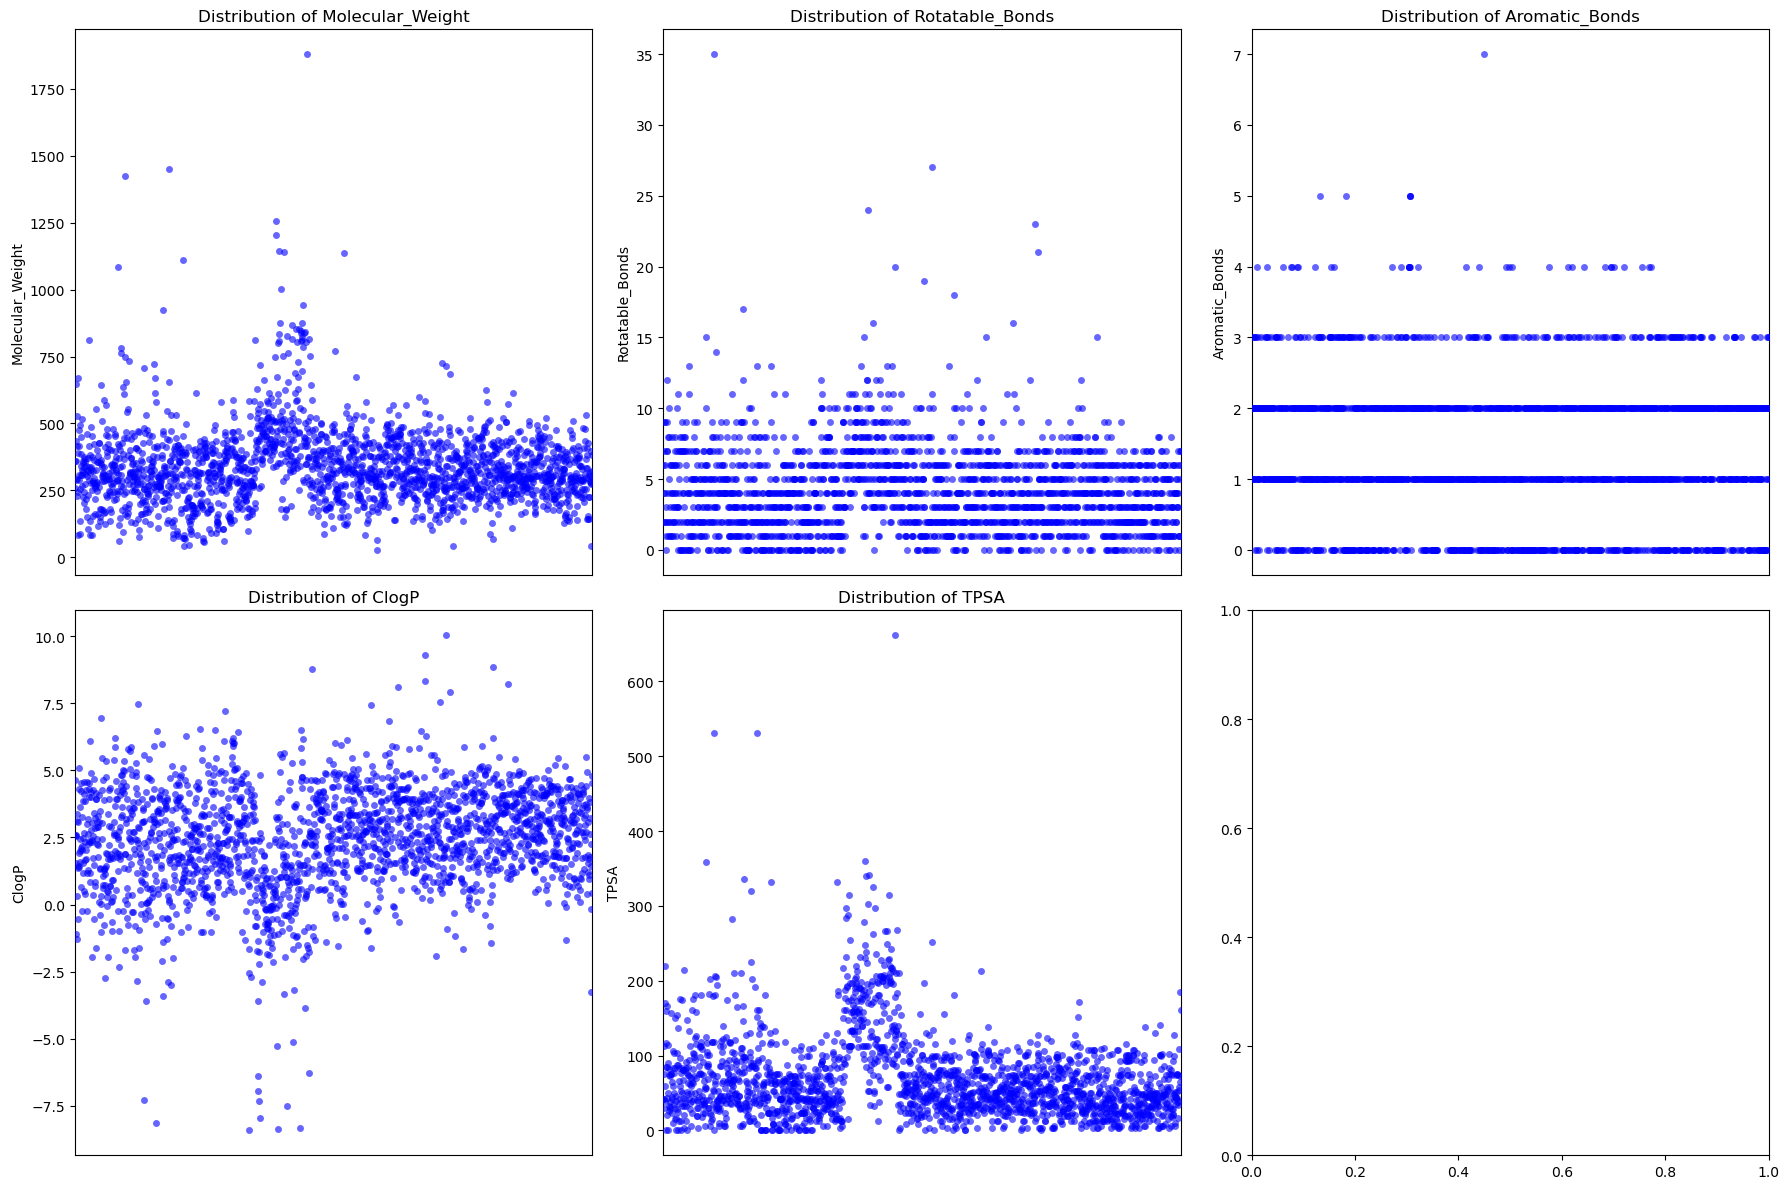

In [5]:
def plot_property_distributions(df):
    """
    Generate jitter plots for the distribution of selected molecular properties
    """
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, prop in enumerate(properties):
        sns.stripplot(x="num", y=prop, data=df, jitter=True, alpha=0.6, color="blue", ax=axes[i])        
        axes[i].set_xticks([])  # Remove x-axis labels
        axes[i].set_title(f"Distribution of {prop}")
        axes[i].set_ylabel(prop)
        axes[i].set_xlabel("")

    plt.tight_layout()
    plt.show()

plot_property_distributions(library)


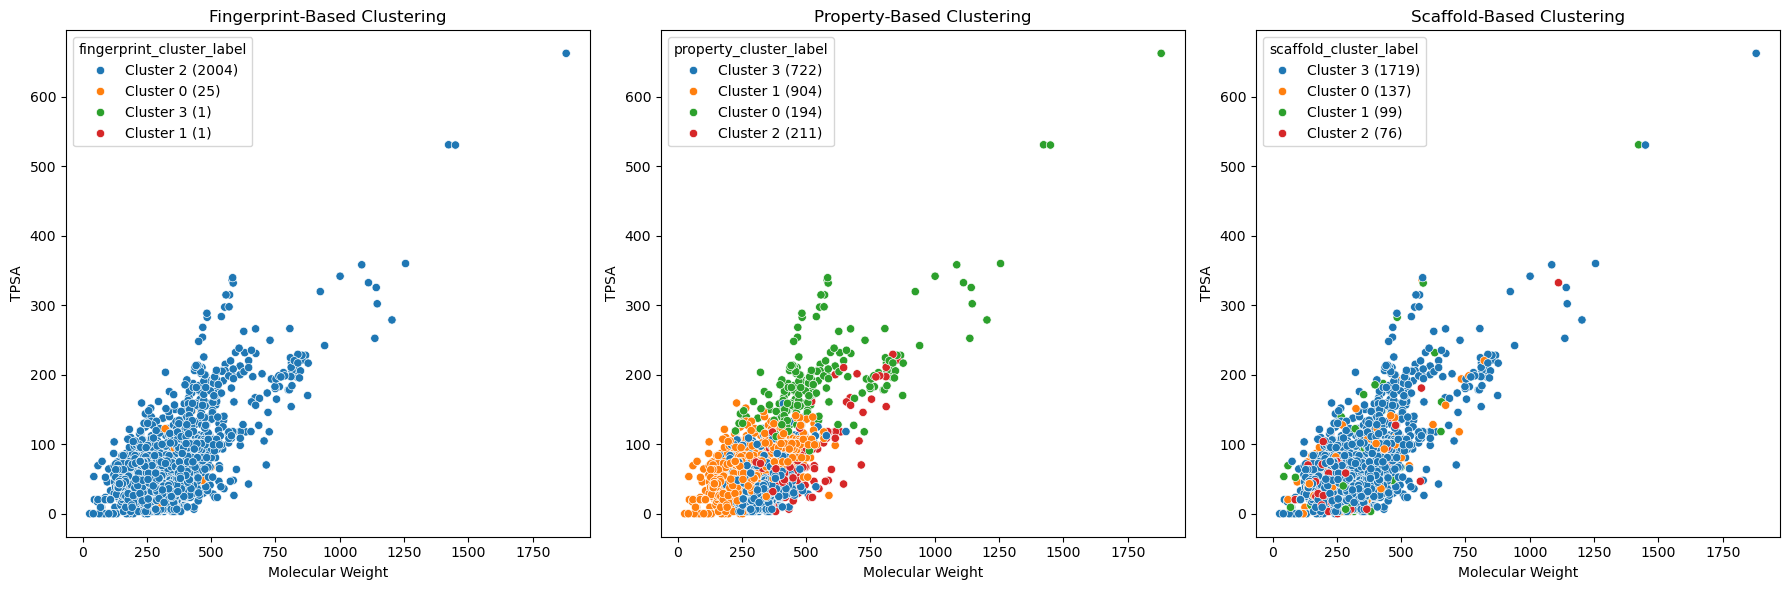

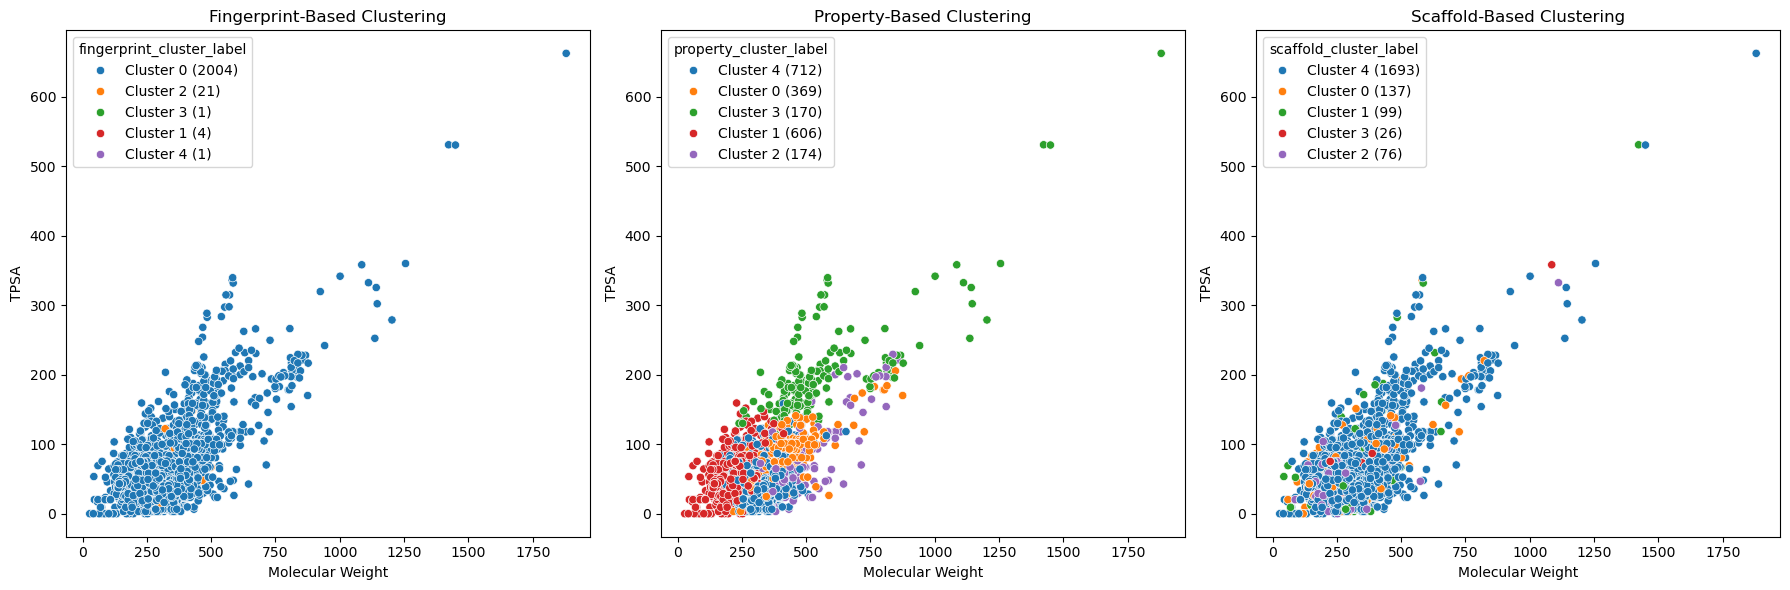

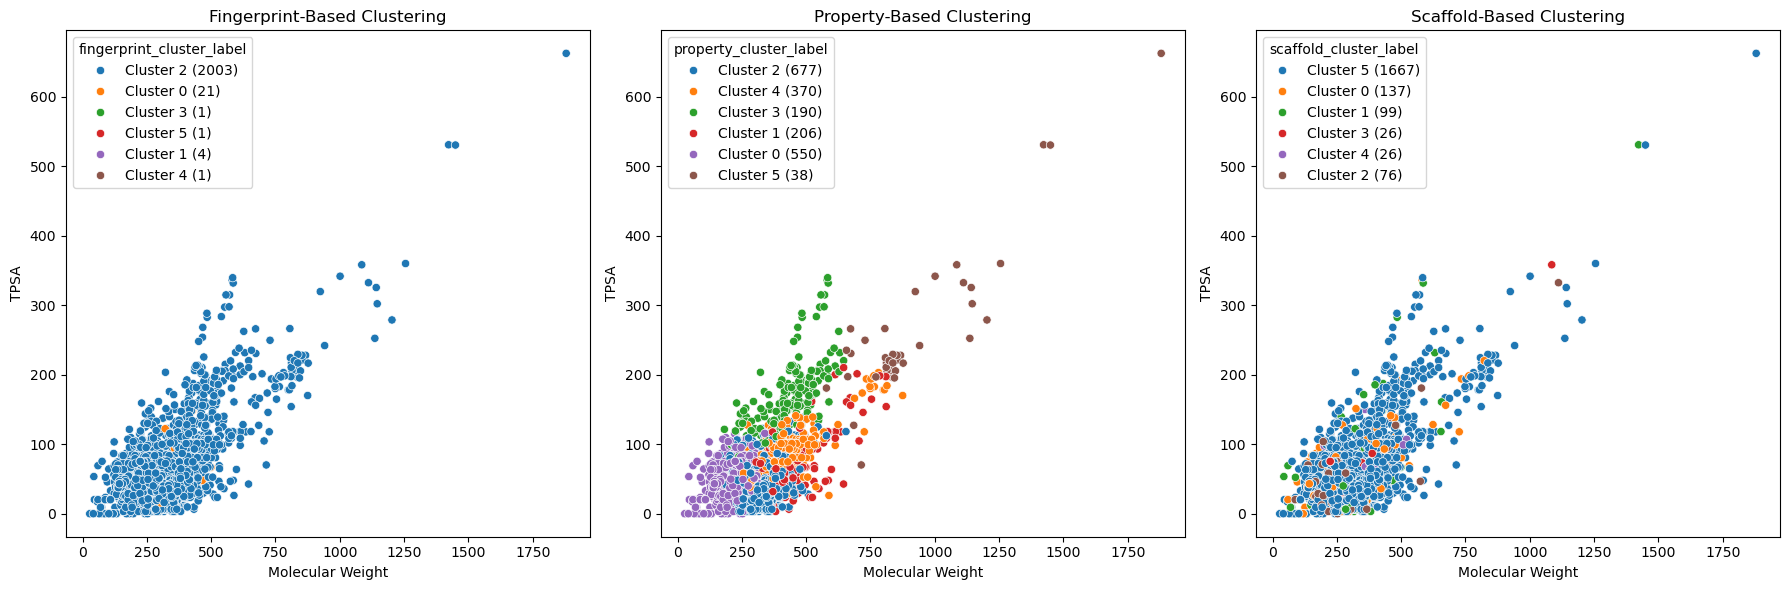

In [24]:
def cluster_by_fingerprint(df, n_clusters=5):
    """Hierarchical clustering based on Tanimoto similarity."""
    
    # Remove molecules with missing fingerprints
    df = df[df['fingerprint'].notna()].copy()
    fingerprints = df['fingerprint'].tolist()
    num_mols = len(fingerprints)

    if num_mols == 0:
        raise ValueError("No valid fingerprints available for clustering!")

    # Compute Tanimoto similarity matrix
    similarity_matrix = np.zeros((num_mols, num_mols))
    for i in range(num_mols):
        for j in range(i, num_mols):
            if fingerprints[i] is not None and fingerprints[j] is not None:
                sim = Chem.DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            else:
                sim = 0  # Default similarity for None cases
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance

    # Use metric instead of affinity
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    df['fingerprint_cluster'] = clustering.fit_predict(distance_matrix)
    return df


def cluster_by_properties(df, n_clusters=5):
    """K-means clustering on normalized molecular properties."""
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
    scaler = MinMaxScaler()
    normalized_props = scaler.fit_transform(df[properties])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['property_cluster'] = kmeans.fit_predict(normalized_props)
    return df

def get_murcko_scaffold(mol):
    """Extract Murcko scaffold."""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol) if mol else None

def cluster_by_scaffold(df, n_scaff=4):
    """Clusters molecules by Murcko scaffold, grouping common scaffolds separately."""
    df['scaffold'] = df['standardized_mol'].apply(get_murcko_scaffold)
    scaffold_counts = Counter(df['scaffold'].dropna())
    top_scaffolds = [scaffold for scaffold, count in scaffold_counts.most_common(n_scaff)]  # Top n scaffolds

    def assign_scaffold_cluster(scaffold):
        return top_scaffolds.index(scaffold) if scaffold in top_scaffolds else len(top_scaffolds)  # Assign 'other'

    df['scaffold_cluster'] = df['scaffold'].apply(assign_scaffold_cluster)
    return df

def main_clustering_pipeline(df, n_clust=5):
    """Runs all clustering methods, computes similarity scores, and visualizes results."""
    df = cluster_by_fingerprint(df, n_clust)
    df = cluster_by_properties(df, n_clust)
    df = cluster_by_scaffold(df, n_clust-1)

    # Plot clustering results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cluster_types = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster']
    titles = ["Fingerprint-Based Clustering", "Property-Based Clustering", "Scaffold-Based Clustering"]

    for i, cluster_col in enumerate(cluster_types):
        # Count occurrences of each cluster
        cluster_counts = df[cluster_col].value_counts().to_dict()
        # Rename clusters
        df[f"{cluster_col}_label"] = df[cluster_col].apply(
            lambda x: f"Cluster {x} ({cluster_counts[x]})"
        )

        # Plot with updated labels
        sns.scatterplot(
            x=df['Molecular_Weight'], 
            y=df['TPSA'], 
            hue=df[f"{cluster_col}_label"], 
            palette="tab10", 
            ax=axes[i]
        )

        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Molecular Weight")
        axes[i].set_ylabel("TPSA")

    plt.tight_layout()
    plt.show()
    
    return df

clustered_df_4 = main_clustering_pipeline(library, n_clust=4)
clustered_df_5 = main_clustering_pipeline(library, n_clust=5)
clustered_df_6 = main_clustering_pipeline(library, n_clust=6)


In [25]:
clustered_df_5.head()

,num,name,p_np,smiles,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster,fingerprint_cluster_label,property_cluster_label,scaffold_cluster_label
0,1,Propanolol,p,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ded60>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0086d0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",259.349,6.0,2.0,2.57750,41.49,0,4,c1ccc2ccccc2c1,4,Cluster 0 (2004),Cluster 4 (712),Cluster 4 (1693)
1,2,Terbutylchlorambucil,p,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7f394f0deeb0>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008740>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",360.325,9.0,1.0,4.63500,29.54,0,0,c1ccccc1,0,Cluster 0 (2004),Cluster 0 (369),Cluster 0 (137)
2,3,40730,p,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0dee40>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0087b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",361.373,2.0,2.0,1.54400,75.01,0,4,O=c1ccn2c3c(c(N4CCNCC4)ccc13)OCC2,4,Cluster 0 (2004),Cluster 4 (712),Cluster 4 (1693)
3,4,24,p,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba120>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008660>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",290.407,7.0,1.0,2.57750,41.57,0,0,c1ccc(CN2CCCCC2)cc1,4,Cluster 0 (2004),Cluster 0 (369),Cluster 4 (1693)
4,5,cloxacillin,p,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba270>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008890>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",435.889,4.0,2.0,2.54872,112.74,0,4,O=C(NC1C(=O)N2CCSC12)c1conc1-c1ccccc1,4,Cluster 0 (2004),Cluster 4 (712),Cluster 4 (1693)


So when looking at setting up a stratified split approach, originally I would have wanted to use the fingerprint clusters. However, unfortunately, there is consistently at least one cluster that only contains one molecule. This can't be used for the stratified approach. We want a more well-rounded set of clusters. Based on the above, that would happen to be n=5 it looks like.

### Splitting up test and training data

In [27]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

df_selected_clusters = clustered_df_5

# Drop cluster label columns
columns_to_drop = [
    "fingerprint_cluster_label", "property_cluster_label", "scaffold_cluster_label"
]
df_cleaned = df_selected_clusters.drop(columns=columns_to_drop, errors="ignore").reset_index(drop=True)

# Choose a stratification column (adjust as needed)
stratify_col = "property_cluster"

# Stratified split (80% train, 20% test)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

df_cleaned["set_label"] = "train"  # Default to train

for train_idx, test_idx in split.split(df_cleaned, df_cleaned[stratify_col]):
    df_cleaned.loc[test_idx, "set_label"] = "test"  # Mark test rows

# Save the labeled dataset
df_cleaned.to_csv("dataset_with_set_labels.csv", index=False)

print("Dataset labeled with 'train' and 'test' in 'set_label' column.")

train_set = df_cleaned[df_cleaned["set_label"] == "train"]
test_set = df_cleaned[df_cleaned["set_label"] == "test"]


Dataset labeled with 'train' and 'test' in 'set_label' column.


### Analysis between test and train set of properties

In [35]:

# Find exact dupes
exact_duplicates = train_set[train_set["standardized_mol"].isin(test_set["standardized_mol"])]

# Compute Tanimoto similarity
similar_pairs = []
threshold = 0.85  # Similarity threshold for possible leakage based on literature

for test_idx, test_fp in zip(test_set.index, test_set["fingerprint"]):
    for train_idx, train_fp in zip(train_set.index, train_set["fingerprint"]):
        similarity = DataStructs.FingerprintSimilarity(test_fp, train_fp)
        if similarity >= threshold:
            similar_pairs.append((train_idx, test_idx, similarity))

# Convert to DataFrame
similar_molecules_df = pd.DataFrame(similar_pairs, columns=["Train_Index", "Test_Index", "Tanimoto_Similarity"])

train_indices_to_remove = set(similar_molecules_df["Train_Index"])
test_indices_to_remove = set(similar_molecules_df["Test_Index"])

# Create a new DataFrame without similar molecules
df_cleaned_no_leakage = df_cleaned.drop(index=train_indices_to_remove.union(test_indices_to_remove))

# Save the cleaned dataset
df_cleaned_no_leakage.to_csv("dataset_no_leakage.csv", index=False)

# Display summary
print(f"Removed {len(train_indices_to_remove) + len(test_indices_to_remove)} molecules due to potential leakage.")
print(f"Final dataset size: {df_cleaned_no_leakage.shape[0]} rows")

# Display cleaned dataset
df_cleaned_no_leakage.head()

Removed 115 molecules due to potential leakage.
Final dataset size: 1916 rows


,num,name,p_np,smiles,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster,set_label
0,1,Propanolol,p,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ded60>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0086d0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",259.349,6.0,2.0,2.57750,41.49,0,4,c1ccc2ccccc2c1,4,train
1,2,Terbutylchlorambucil,p,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7f394f0deeb0>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008740>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",360.325,9.0,1.0,4.63500,29.54,0,0,c1ccccc1,0,train
2,3,40730,p,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0dee40>,<rdkit.Chem.rdchem.Mol object at 0x7f394f0087b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",361.373,2.0,2.0,1.54400,75.01,0,4,O=c1ccn2c3c(c(N4CCNCC4)ccc13)OCC2,4,train
4,5,cloxacillin,p,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba270>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008890>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",435.889,4.0,2.0,2.54872,112.74,0,4,O=C(NC1C(=O)N2CCSC12)c1conc1-c1ccccc1,4,test
5,6,cefoperazone,p,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...,<rdkit.Chem.rdchem.Mol object at 0x7f394f0ba2e0>,<rdkit.Chem.rdchem.Mol object at 0x7f394f008900>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",645.680,9.0,2.0,-1.11200,220.26,0,3,O=C1NCCN(C(=O)NC(C(=O)NC2C(=O)N3C=C(CSc4nnn[nH...,4,test


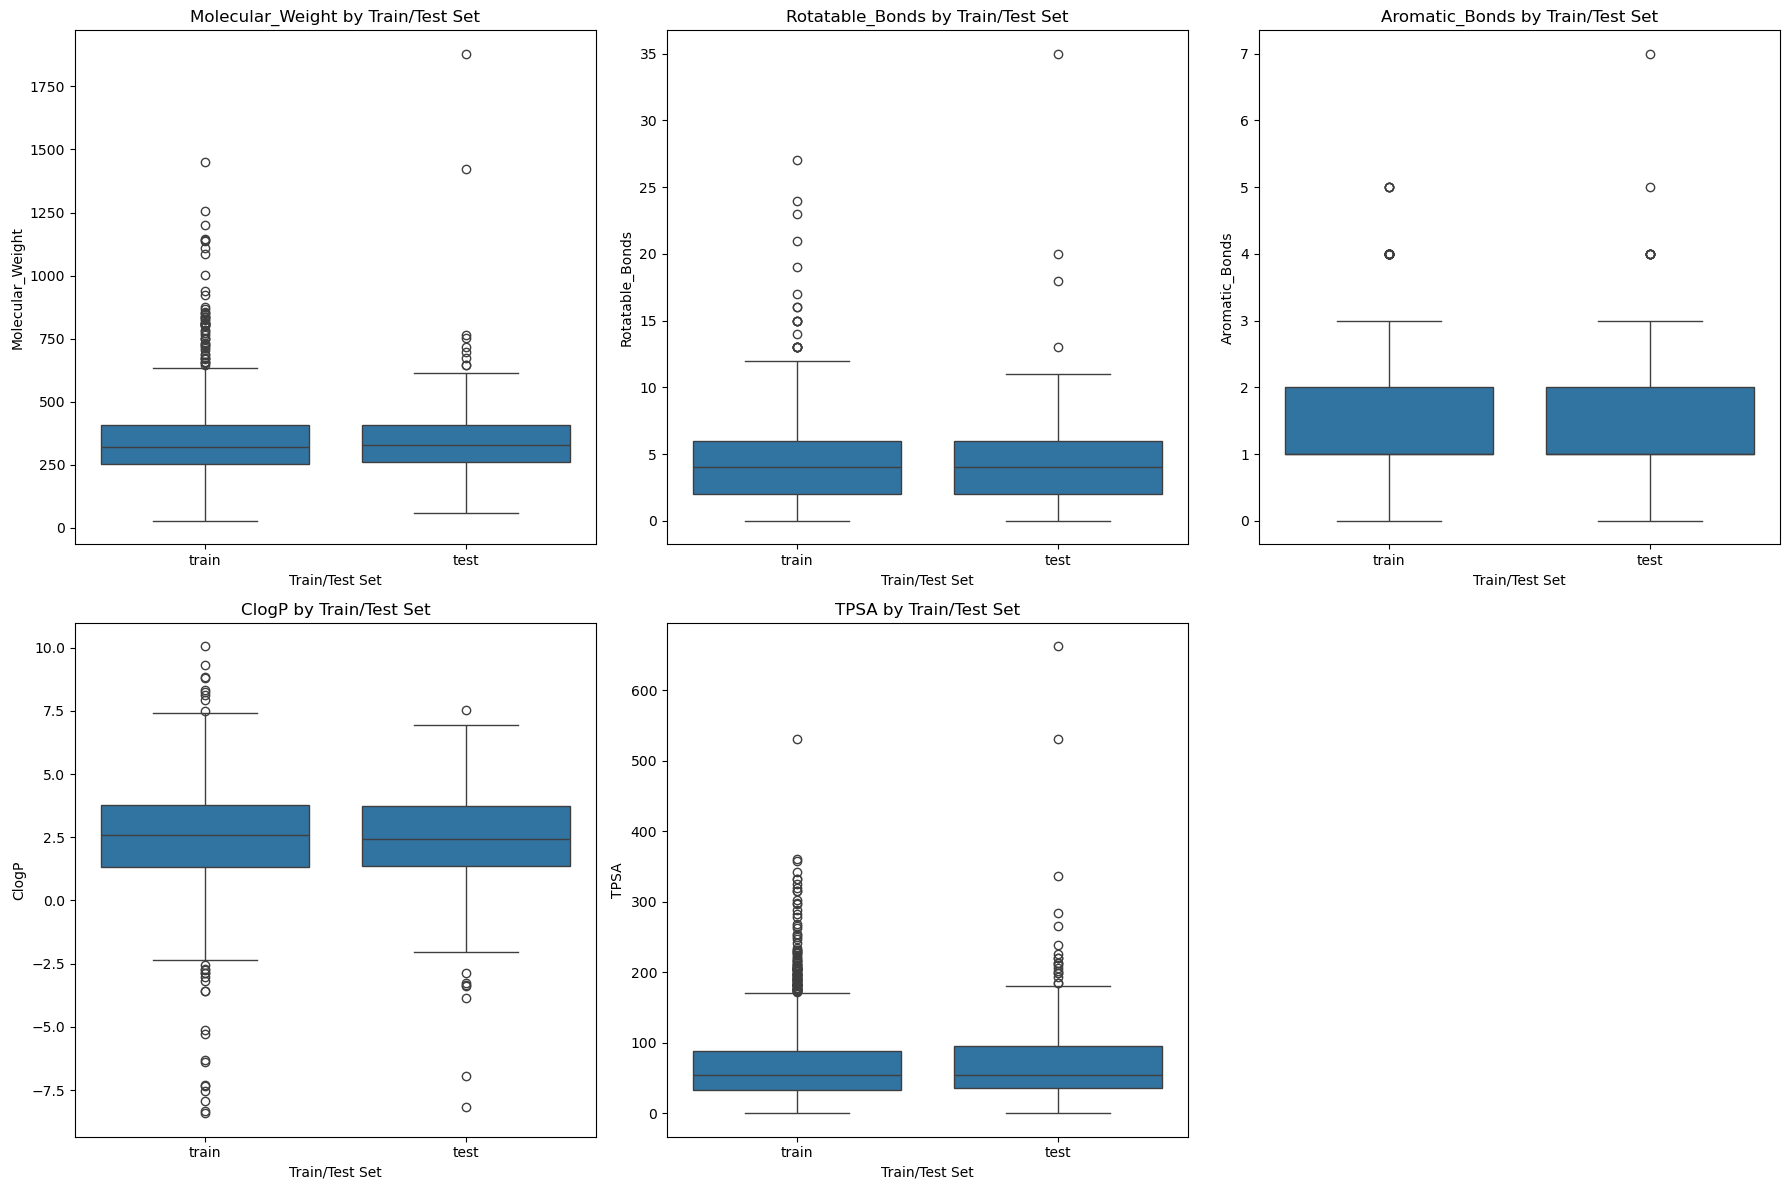

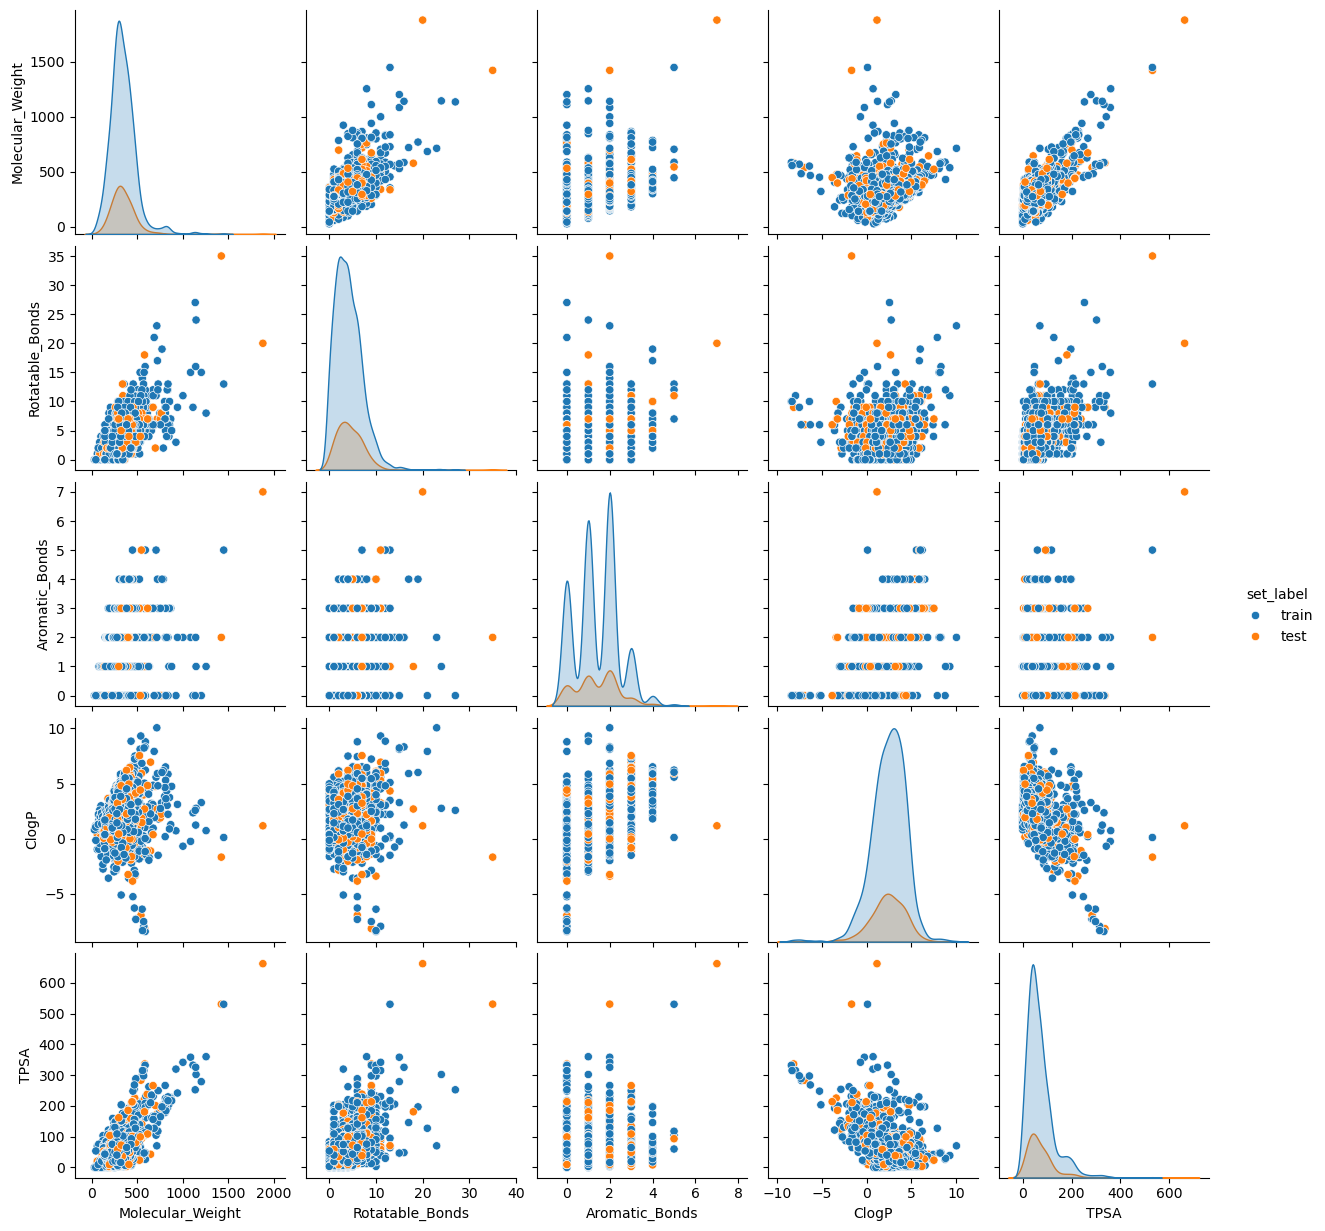

In [36]:
columns_to_plot = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Plot each feature in the grid
for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=df_cleaned_no_leakage, x="set_label", y=col, ax=axes[i])
    axes[i].set_title(f"{col} by Train/Test Set")
    axes[i].set_xlabel("Train/Test Set")
    axes[i].set_ylabel(col)

# Remove empty plot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Pair plot to explore relationships between descriptors
sns.pairplot(df_cleaned_no_leakage, vars=["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"], hue="set_label")
plt.show()

The distribution of molecular properties (Molecular Weight, Rotatable Bonds, Aromatic Bonds, ClogP, and TPSA) appears similar between the train and test sets, suggesting a balanced split. Molecular Weight and TPSA show some outliers in both sets, but their medians and IQRs are well aligned, indicating that extreme values are equally present in both sets. ClogP exhibits a broad range, but the distribution in test and train appears to be consistent. The number of Rotatable and Aromatic Bonds also follows a similar distribution across train and test sets, showing no significant bias in structural flexibility and aromaticity.

The test set molecules (orange points) are well-distributed among the training set molecules (blue points), indicating that the clustering process successfully preserved diversity. No obvious clustering of test molecules in certain regions suggests that the train-test split is not biased toward a specific chemical space. The correlations between different molecular properties are similar between train and test sets, confirming that the test set represents a reasonable subset of the training data. A few outliers are seen in properties like TPSA and Molecular Weight, though, which could affect model generalizability. This is not exactly something I'm concerned about considering this model will be pretty singularly focused.

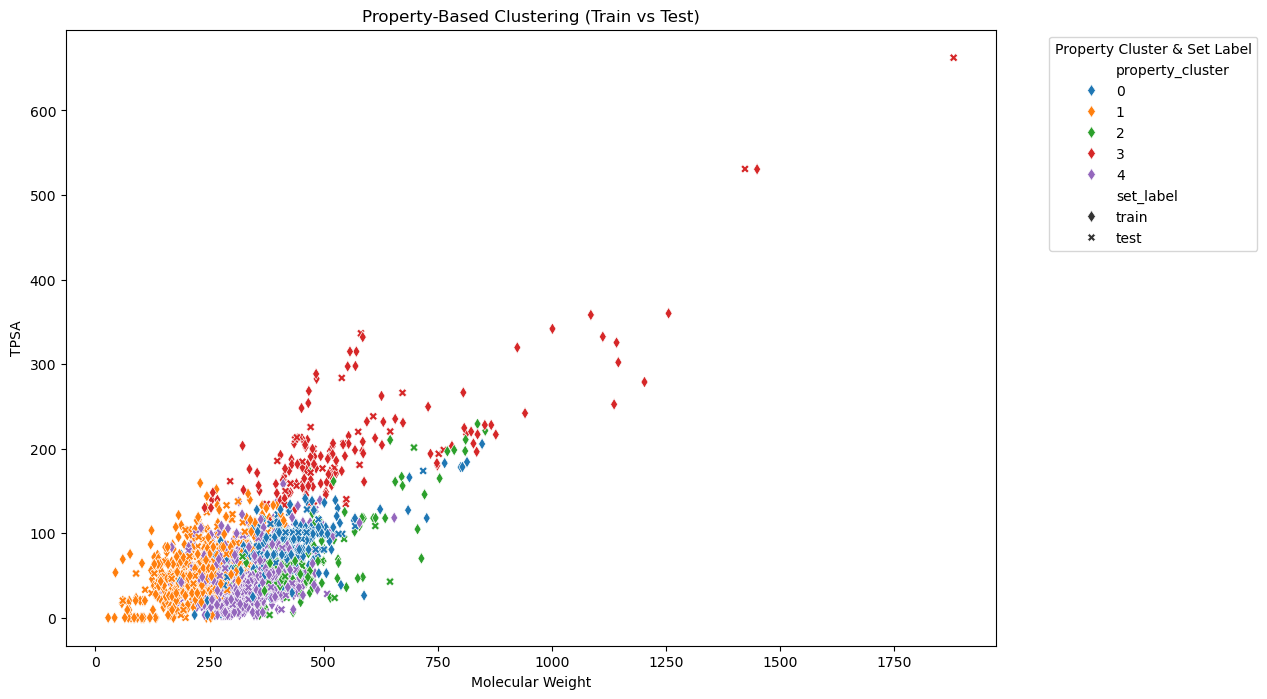

In [41]:
def plot_property_clustering(df):
    """Plot the property-based clustering with train/test labels."""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot colored by property clusters, with different markers for train/test sets
    sns.scatterplot(
        data=df, x="Molecular_Weight", y="TPSA",
        hue="property_cluster", style="set_label",
        palette="tab10", markers={"train": "d", "test": "X"}
    )

    plt.title("Property-Based Clustering (Train vs Test)")
    plt.xlabel("Molecular Weight")
    plt.ylabel("TPSA")
    plt.legend(title="Property Cluster & Set Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Ensure df_clustered_no_leakage is available before running
plot_property_clustering(df_cleaned_no_leakage)

We see a pretty good dispersion of our test versus training set when looking back at the property based clustering above. Now our next step is to actually create the predictive model.